<a href="https://colab.research.google.com/github/tnc-br/ddf_common/blob/furthest_points/dataset_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports and modules.
%pip install opencv-python
%pip install matplotlib
%pip install pandas

from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import matplotlib.animation as animation
from matplotlib import rc
from typing import List
from numpy.random import MT19937, RandomState, SeedSequence
import pandas as pd
from tqdm import tqdm
from io import StringIO
import xgboost as xgb
import os
import math
import glob

rc('animation', html='jshtml')

import sys
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_source_control_pane()
# ddfimport.ddf_import_common()

Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 5.50 KiB | 5.50 MiB/s, done.
Resolving deltas: 100% (4/4), done.


interactive(children=(Text(value='', description='Email', placeholder='Enter email'), Text(value='', descripti…

In [10]:
import dataset
import importlib
importlib.reload(dataset)

<module 'dataset' from '/content/gdrive/MyDrive/furthest_points/ddf_common/dataset.py'>

In [3]:
import pytest

def test_partition_data_furthest_points_not_enough_data():
  with pytest.raises(AssertionError):
    test_data = pd.DataFrame({
      "long": [-62.5, -50.0, -20.0, 0.0, 100.0],
      "lat": [-5.0, -3.0, -2.0, -1.0, 0.0],
    })
    partitioned_dataset = dataset.partition(
        test_data, dataset.PartitionStrategy.FURTHEST_POINTS)

test_partition_data_furthest_points_not_enough_data()

100
[(5.70087712549569, (-5, 3)), (5.1478150704935, (2, -5)), (4.301162633521313, (3, -3)), (4.301162633521313, (-3, 3)), (2.1213203435596424, (1, -2)), (6.363961030678928, (-5, -5)), (4.527692569068709, (-5, 0)), (4.527692569068709, (0, -5)), (4.949747468305833, (3, -4)), (4.527692569068709, (-5, -1)), (2.9154759474226504, (-3, -2)), (1.5811388300841898, (1, 0)), (2.9154759474226504, (2, 1)), (4.743416490252569, (1, -5)), (2.5495097567963922, (-3, -1)), (2.5495097567963922, (-1, -3)), (3.5355339059327378, (2, 2)), (3.8078865529319543, (-2, 3)), (1.5811388300841898, (0, 1)), (2.5495097567963922, (2, 0)), (1.5811388300841898, (-2, 0)), (4.949747468305833, (3, 3)), (5.70087712549569, (-4, 4)), (5.1478150704935, (-3, 4)), (3.8078865529319543, (-2, -4)), (5.70087712549569, (4, -4)), (3.5355339059327378, (3, 0)), (6.363961030678928, (-5, 4)), (1.5811388300841898, (0, -2)), (3.5355339059327378, (-1, -4)), (4.301162633521313, (-3, -4)), (6.363961030678928, (4, -5)), (2.1213203435596424, (-2, 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

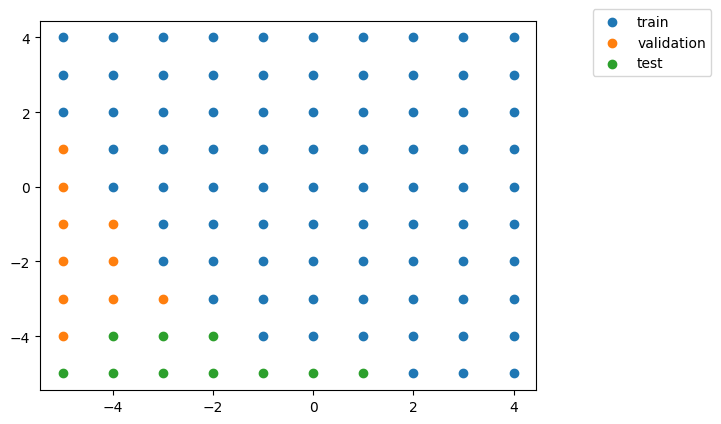

In [15]:
import matplotlib.pyplot as plt

np.random.seed(123)

def test_partition_data_furthest_points():
  longs = []
  lats = []
  for long in range(-5, 5, 1):
    for lat in range(-5, 5, 1):
      longs.append(long)
      lats.append(lat)
  print(len(longs))
  test_data = pd.DataFrame({
    "long": longs,
    "lat": lats,
  })
  partitioned_dataset = dataset.partition(test_data, dataset.PartitionStrategy.FURTHEST_POINTS)
  plt.scatter(
      partitioned_dataset.train['long'],
      partitioned_dataset.train['lat'],
      label='train'
  )
  plt.scatter(
      partitioned_dataset.validation['long'],
      partitioned_dataset.validation['lat'],
      label='validation'
  )
  plt.scatter(
      partitioned_dataset.test['long'],
      partitioned_dataset.test['lat'],
      label='test'
  )
  plt.legend(bbox_to_anchor=(1.1, 1.05))

test_partition_data_furthest_points()

# preprocess_sample_data Tests

In [3]:
from pandas.util.testing import assert_frame_equal

# Average and variance test
def average_variance_test():
  test_df = pd.DataFrame({
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x": [3.0, 3.0, 3.0],
      "y": [8.0, 0.0, -3.0]}
  )
  feature_columns = ["lat", "long"]
  label_columns = ["x", "y"]
  aggregate_columns = ["lat", "long"]
  keep_grouping=True

  test_sample = dataset.preprocess_sample_data(test_df, feature_columns, label_columns, aggregate_columns, keep_grouping)
  expected_df = pd.DataFrame({
      "lat": [0.0, 1.0],
      "long": [3.0, 6.0],
      "x_mean": [3.0, 3.0],
      "x_variance": [0.0, np.nan],
      "y_mean": [4.0, -3.0],
      "y_variance": [32.0, np.nan]
  })
  assert_frame_equal(expected_df, test_sample)

def average_variance_test_no_grouping():
  test_df = pd.DataFrame({
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x": [3.0, 3.0, 3.0],
      "y": [8.0, 0.0, -3.0]}
  )
  feature_columns = ["lat", "long"]
  label_columns = ["x", "y"]
  aggregate_columns = ["lat", "long"]
  keep_grouping=False

  test_sample = dataset.preprocess_sample_data(test_df, feature_columns, label_columns, aggregate_columns, keep_grouping)
  expected_df = pd.DataFrame({
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x_mean": [3.0, 3.0, 3.0],
      "x_variance": [0.0, 0.0, np.nan],
      "y_mean": [4.0, 4.0, -3.0],
      "y_variance": [32.0, 32.0, np.nan]
  })
  assert_frame_equal(expected_df, test_sample)

def average_variance_test_keep_nonnumerical_columns():
  test_df = pd.DataFrame({
      "code": ["a", "b", "c"],
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x": [3.0, 3.0, 3.0],
      "y": [8.0, 0.0, -3.0]}
  )
  feature_columns = ["code", "lat", "long"]
  label_columns = ["x", "y"]
  aggregate_columns = ["lat", "long"]
  keep_grouping=True

  test_sample = dataset.preprocess_sample_data(test_df, feature_columns, label_columns, aggregate_columns, keep_grouping)
  expected_df = pd.DataFrame({
      "lat": [0.0, 1.0],
      "long": [3.0, 6.0],
      "code": ["a", "c"],
      "x_mean": [3.0, 3.0],
      "x_variance": [0.0, np.nan],
      "y_mean": [4.0, -3.0],
      "y_variance": [32.0, np.nan]
  })
  assert_frame_equal(expected_df, test_sample)

average_variance_test()
average_variance_test_no_grouping()
average_variance_test_keep_nonnumerical_columns()

<ipython-input-3-89f1482dfa8d>:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/content/gdrive/MyDrive/furthest_points/ddf_common/dataset.py:531: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean().reset_index()
/content/gdrive/MyDrive/furthest_points/ddf_common/dataset.py:535: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  variances = grouped.var().reset_index()
/content/gdrive/MyDrive/furthest_points/ddf_common/dataset.py:531: FutureWarning: The default value of numeric_o

In [4]:
# @title Load example CSV
jun23_reference_data = """
ID,Cod Lab,Code,Species,Scientific_name,Genus,Family,Point,Origin,State,date sample havest,lat,long,d15N_wood,%N_wood,d13C_wood,%C_wood,d13C_cel,%C_cel,d18O_cel_CENA,d18O_cel_Davis,d18O_cel_analysis,d18O_cel,VPD,RH,PET,DEM,PA,Mean Annual Temperature,Mean Annual Precipitation,Iso_Oxi_Stack_mean_TERZER
1,ZAC 730,mad53,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,0,itacoatiara,amazonas,Jul-22,-2.499,-59.121,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
2,ZAC 731,mad53,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,25,itacoatiara,amazonas,Jul-22,-2.499,-59.121,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
3,ZAC 732,mad53,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,50,itacoatiara,amazonas,Jul-22,-2.499,-59.121,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
4,ZAC 733,mad53,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,75,itacoatiara,amazonas,Jul-22,-2.499,-59.121,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
5,ZAC 734,mad53,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,100,itacoatiara,amazonas,Jul-22,-2.499,-59.121,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
6,ZAC 735,mad54,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,0,itacoatiara,amazonas,Jul-22,-2.496,-59.126,0,0,0,0,0,0,0,0,0,0,0.76667,0.78997,98.28333,103,1000.65411,26.725,2264,-3.70363
7,ZAC 736,mad54,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,25,itacoatiara,amazonas,Jul-22,-2.496,-59.126,0,0,0,0,0,0,0,0,0,0,0.76667,0.78997,98.28333,103,1000.65411,26.725,2264,-3.70363
8,ZAC 737,mad54,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,50,itacoatiara,amazonas,Jul-22,-2.496,-59.126,0,0,0,0,0,0,0,0,0,0,0.76667,0.78997,98.28333,103,1000.65411,26.725,2264,-3.70363
9,ZAC 738,mad54,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,75,itacoatiara,amazonas,Jul-22,-2.496,-59.126,0,0,0,0,0,0,0,0,0,0,0.76667,0.78997,98.28333,103,1000.65411,26.725,2264,-3.70363
10,ZAC 739,mad54,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,100,itacoatiara,amazonas,Jul-22,-2.496,-59.126,0,0,0,0,0,0,0,0,0,0,0.76667,0.78997,98.28333,103,1000.65411,26.725,2264,-3.70363
11,ZAC 740,mad55,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,0,itacoatiara,amazonas,Jul-22,-2.495,-59.12,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
12,ZAC 741,mad55,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,25,itacoatiara,amazonas,Jul-22,-2.495,-59.12,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
13,ZAC 742,mad55,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,50,itacoatiara,amazonas,Jul-22,-2.495,-59.12,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
14,ZAC 743,mad55,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,75,itacoatiara,amazonas,Jul-22,-2.495,-59.12,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
15,ZAC 744,mad55,macaranduba,Manilkara huberi (Ducke) A.Chev.,manilkara,sapotaceae,100,itacoatiara,amazonas,Jul-22,-2.495,-59.12,0,0,0,0,0,0,0,0,0,0,0.775,0.78866,98.45,139,996.36792,26.79167,2253,-3.70363
1094,ZAC 623,madsd10,ucuuba_puna,Iryanthera  laevis Markgr,iryanthera,myristicaceae,75,manicoré,amazonas,Mar-14,-6.009706576,-61.8686565,0,0,0,0,0,0,0,0,0,0,0.77083,0.79509,93.975,71,1004.47662,27.2,1996,-4.05694
1095,ZAC 624,madsd10,ucuuba_puna,Iryanthera  laevis Markgr,iryanthera,myristicaceae,100,manicoré,amazonas,Mar-14,-6.009706576,-61.8686565,0,0,0,0,0,0,0,0,0,0,0.77083,0.79509,93.975,71,1004.47662,27.2,1996,-4.05694
"""

In [5]:
def xgb_equivalence():
  with open(raster.get_sample_db_path("scratch_file.txt"), "w") as f:
    f.write(jun23_reference_data)

  pds1 = dataset.partitioned_reference_data("scratch_file.txt")

  # The equivalent...
  df = pd.read_csv(raster.get_sample_db_path("scratch_file.txt"),
    encoding="ISO-8859-1", sep=',')
  df = dataset.partition(df.rename(
      columns={'long': 'lon' })).train
  df = df[['Code', 'lat', 'lon', 'd18O_cel']]
  df = df[df['d18O_cel'].notna()]
  df = df.groupby(['lat', 'lon'])
  df = df.mean().reset_index().rename(
      columns={'d18O_cel': 'cellulose_oxygen_ratio' }).reset_index()
  df.drop('index', inplace=True, axis=1)

  fdf = dataset.add_features_from_rasters(df, [raster.relative_humidity_geotiff(),
      raster.temperature_geotiff(),
      raster.vapor_pressure_deficit_geotiff(),
      raster.atmosphere_isoscape_geotiff()])

  fdf1 = fdf.sort_index(axis=1).reset_index(drop=True)
  fdf2 = pds1.train.sort_index(axis=1).reset_index(drop=True)

  assert_frame_equal(fdf1, fdf2)

  xgb_equivalence()

In [6]:
from pandas.testing import assert_frame_equal

def test_partition_data_fixed():
  '''
  For reference:
  _FIXED_PARTITION_STRATEGY = FixedPartitionStrategy(
    # Train
    DatasetGeographicPartitions(
        min_longitude=-62.5,
        max_longitude=float('inf'),
        min_latitude=-5,
        max_latitude=float('inf'),
    ),
    # Validation
    DatasetGeographicPartitions(
        min_longitude=float('-inf'),
        max_longitude=-62.5,
        min_latitude=-5,
        max_latitude=float('inf')
    ),
    # Test
    DatasetGeographicPartitions(
        min_longitude=float('-inf'),
        max_longitude=float('inf'),
        min_latitude=float('-inf'),
        max_latitude=-5
    )
  )
  '''
  train_long_values = [-62.5, -50.0, -20.0, 0.0, 100.0]
  train_lat_values = [-5.0, -3.0, -2.0, -1.0, 0.0]

  validation_long_values = [-80.0, -70.0, -63.0]
  validation_lat_values = [-5.0, -2.0, 5.0]

  test_long_values = [-50.0, -30.0, -40.0, 0.0, 50.0, 100.0]
  test_lat_values = [-50.0, -30.0, -40.0, -20.0, -10.0, -5.1]

  test_data = pd.DataFrame({
      "long": train_long_values + test_long_values + validation_long_values,
      "lat": train_lat_values + test_lat_values + validation_lat_values,
  })

  partitioned_dataset = dataset.partition(test_data, dataset.PartitionStrategy.FIXED)

  assert_frame_equal(
      partitioned_dataset.train.reset_index(drop=True),
      pd.DataFrame({
          "long": train_long_values,
          "lat": train_lat_values,
      }).reset_index(drop=True)
  )
  assert_frame_equal(
      partitioned_dataset.validation.reset_index(drop=True),
      pd.DataFrame({
          "long": validation_long_values,
          "lat": validation_lat_values,
      }).reset_index(drop=True)
  )
  assert_frame_equal(
      partitioned_dataset.test.reset_index(drop=True),
      pd.DataFrame({
          "long": test_long_values,
          "lat": test_lat_values,
      }).reset_index(drop=True)
  )

test_partition_data_fixed()

In [7]:
def test_partition_data_random():
  '''
  For reference:
  TRAIN_VALIDATION_TEST_RATIOS = [0.8, 0.1, 0.1]
  '''

  test_data = pd.DataFrame({
      "long": [-62.5, -50.0, -20.0, 0.0, 100.0, -62.5, -50.0, -20.0, 0.0, 100.0],
      "lat": [-5.0, -3.0, -2.0, -1.0, 0.0, -5.0, -3.0, -2.0, -1.0, 0.0],
  })

  partitioned_dataset = dataset.partition(test_data, dataset.PartitionStrategy.RANDOM)

  print(partitioned_dataset.train)
  print(partitioned_dataset.validation)
  print(partitioned_dataset.test)

  assert(partitioned_dataset.train.shape[0] == 8)
  assert(partitioned_dataset.validation.shape[0] == 1)
  assert(partitioned_dataset.test.shape[0] == 1)

test_partition_data_random()

    long  lat
0  -62.5 -5.0
1  -50.0 -3.0
2  -20.0 -2.0
3    0.0 -1.0
4  100.0  0.0
5  -62.5 -5.0
6  -50.0 -3.0
7  -20.0 -2.0
   long  lat
8   0.0 -1.0
    long  lat
9  100.0  0.0


In [ ]:
TEST_ISOSCAPE_MEANS_FILENAME = "canonical/kriging_fixed_means.tiff" #@param
TEST_ISOSCAPE_VARS_FILENAME = "canonical/kriging_fixed_vars.tiff" #@param

In [ ]:
import raster

In [ ]:
def create_fraudulent_samples_test():
  # The range of expected values is around 25 for most locations here.
  # We can have samples with less than 5 measurements, but more than 1. We
  # still want to consider them.
  real_samples_data = pd.DataFrame({
      'Code': ["a", "a", "a", "a", "a", "b", "b", "b","b","b","c","c","c"],
      'lat': [-2.499,-2.499,-2.499,-2.499,-2.499, -6.009706576,-6.009706576,-6.009706576,-6.009706576,-6.009706576, -5, -5, -5],
      'long': [-59.121, -59.121, -59.121, -59.121, -59.121, -61.8686565,-61.8686565,-61.8686565,-61.8686565,-61.8686565, -60, -60, -60],
      'd18O_cel': [-20.0, 5.0, 100.0, 5.0, 8.0, 5.0, 0.0, 3.0,
                   -20.0, 25.0, 0.5, 0.5, 0.5],
  })

  mean_iso = raster.load_raster(raster.get_raster_path(TEST_ISOSCAPE_MEANS_FILENAME), use_only_band_index=0)
  element = 'd18O_cel'
  max_trusted_radius = 0.1
  max_fraud_radius = 30
  min_fraud_radius = 5

  fake_sample = (
    dataset.create_fraudulent_samples(real_samples_data,
                                      mean_iso,
                                      [element],
                                      max_trusted_radius,
                                      max_fraud_radius,
                                      min_fraud_radius))
  assert('Code' in fake_sample.columns)
  assert('lat' in fake_sample.columns)
  assert('long' in fake_sample.columns)
  assert('d18O_cel' in fake_sample.columns)
  assert(fake_sample.shape[0] == real_samples_data.shape[0])

create_fraudulent_samples_test()

Driver: GTiff/GeoTIFF
Size is 235 x 234 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0, 5.333333333999995)
Pixel Size = (0.16666666666808508, -0.16666666666808505)


In [ ]:
def create_fraudulent_samples_elements_test():
  # The range of expected values is around 25 for most locations here.
  # We can have samples with less than 5 measurements, but more than 1. We
  # still want to consider them.
  real_samples_data = pd.DataFrame({
      'Code': ["a", "a", "a", "a", "a", "b", "b", "b","b","b","c","c","c"],
      'lat': [-2.499,-2.499,-2.499,-2.499,-2.499, -6.009706576,-6.009706576,-6.009706576,-6.009706576,-6.009706576, -5, -5, -5],
      'long': [-59.121, -59.121, -59.121, -59.121, -59.121, -61.8686565,-61.8686565,-61.8686565,-61.8686565,-61.8686565, -60, -60, -60],
      'd18O_cel': [-20.0, 5.0, 100.0, 5.0, 8.0, 5.0, 0.0, 3.0,
                   -20.0, 25.0, 0.5, 0.5, 0.5],
      'd15N_wood': [8.0, 5.0, 0.0, 3.0,-20.0, 25.0, 0.5, 0.5, 0.5, -20.0, 5.0, 100.0, 5.0],
  })

  mean_iso = raster.load_raster(raster.get_raster_path(TEST_ISOSCAPE_MEANS_FILENAME), use_only_band_index=0)
  elements = ['d18O_cel', 'd15N_wood']
  max_trusted_radius = 0.1
  max_fraud_radius = 30
  min_fraud_radius = 5

  fake_sample = (
    dataset.create_fraudulent_samples(real_samples_data,
                                      mean_iso,
                                      elements,
                                      max_trusted_radius,
                                      max_fraud_radius,
                                      min_fraud_radius))
  assert(fake_sample.shape[0] == real_samples_data.shape[0])
  assert('Code' in fake_sample.columns)
  assert('lat' in fake_sample.columns)
  assert('long' in fake_sample.columns)
  assert('d18O_cel' in fake_sample.columns)
  assert('d15N_wood' in fake_sample.columns)


create_fraudulent_samples_elements_test()

Driver: GTiff/GeoTIFF
Size is 235 x 234 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0, 5.333333333999995)
Pixel Size = (0.16666666666808508, -0.16666666666808505)
